# Attribute

**Direct Reference**: pinn_ode_tutorial-master github repositor

**Original Work**: *Renato Nascimento, Kajetan Fricke, Felipe Viana*
**Reference Github repo** https://github.com/PML-UCF/pinn_ode_tutorial.git

# Libraries and Dependencies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as matplotlib

from torch.nn.parameter import Parameter
from torch import (
    linalg,
    nn,
    Tensor,
    stack,
    cat,
    transpose, 
    optim,
    zeros,
    diag,
    reshape,
    rand,
    tanh,
    mean,
    square
    )

#For Data Generation
from scipy import signal
from scipy import linalg as linalg2
from scipy.integrate import odeint

# Underlying Model and Training Dataset

In [2]:
def compartmentaldiff(y, t, beta, gamma, mu):
    S, I, D, R = y
    Sdot = - (beta / N) * S * I
    Idot = (beta / N) * S * I - gamma * I - mu * I
    Rdot = gamma * I
    Ddot = mu * I

    return Sdot, Idot, Ddot, Rdot

In [12]:
# Initial conditions
Ntrue = 59e6 #true population size
N = 1.0 #population size squished into 1 for ease of training
S0 = (Ntrue - 1)/Ntrue
I0 = N - S0
R0 = 0
D0 = 0
y0 = S0, I0, D0, R0

# A grid of time points (in days)
timesteps = 147
duration = 500
t = np.linspace(0, duration, timesteps)

# compartmental model parameters
beta_syn = 0.191
gamma_syn = 0.05
mu_syn = 0.0294

# Integrate the SIR equations over the time grid, t.
ret = odeint(compartmentaldiff, y0, t, args=(beta_syn, gamma_syn, mu_syn))
S, I, D, R = ret.T
S = np.reshape(S, (len(t), 1))
I = np.reshape(I, (len(t), 1))
D = np.reshape(D, (len(t), 1))
R = np.reshape(R, (len(t), 1))


#reshape time vector
t_data = np.transpose(t)
t_data = np.reshape(t_data, (len(t),1))

# keep clean data
Sc = S
Ic = I
Dc = D
Rc = R

#relative noise
noise = 0.05
S = (1 + noise * np.random.normal(0,1, S.shape)) * S
I = (1 + noise * np.random.normal(0,1, I.shape)) * I
D = (1 + noise * np.random.normal(0,1, D.shape)) * D
R = (1 + noise * np.random.normal(0,1, R.shape)) * R

# sample 50 evenly spaced data points
Strain = S[0:50]
Itrain = I[0:50]
Rtrain = R[0:50]
Dtrain = D[0:50]
ttrain = t[0:50]
print('debug')

debug


# Hybrid RNN Code

### Construct / Deploy Hybrid RNN

In [4]:
class MyRNN(nn.Module):
    def __init__(self, cell, **kwargs):
        super(MyRNN, self).__init__()
        self.cell = cell

    def forward(self, inputs, initial_state):
        # Step into proceeding timestep
        bs, seq_sz, _ = inputs.shape
        state = []
        state.append(initial_state)
        for t in range(1, seq_sz): 
            input = inputs[:, t-1, :]
            state_t = self.cell.forward(input, state[t-1])
            state.append(state[t-1]+state_t)

        return stack((state),dim=1)

### Construct Runge-Kutta Cell

In [5]:
class RungeKuttaIntegratorCell(nn.Module):
    def __init__(self, beta, gamma, mu, u, dt, **kwargs):
        super(RungeKuttaIntegratorCell, self).__init__(**kwargs)

        self.beta_param = Parameter(beta)
        self.gamma_param = Parameter(gamma)
        self.mu_param = Parameter(mu)
        
        # Runge-Kutta iterative vectors
        self.state_size   =  4
        self.A  = Tensor([0., 0.5, 0.5, 1.0])
        self.B  = Tensor([[1/6, 2/6, 2/6, 1/6]])
        self.dt = dt
        
     #force parameters to be in a range
    @property
    def beta(self):
        return tanh(abs(self.beta_param))

    @property
    def gamma(self):
        return tanh(abs(self.gamma_param))

    @property
    def mu(self):
        return tanh(abs(self.mu_param))

    def forward(self, inputs, states):
        y = states
        #Perform Runge-Kutta computation
        ydoti = self._fun(beta, gamma, mu, y)
        yi = y + self.A[0]*ydoti*self.dt
        fn = self._fun(beta, gamma, mu, yi)
        #Perfom Runge-Kutta Computation
        for j in range(1,4):
            yn = y + self.A[j] * ydoti * self.dt
            fn = cat([fn, self._fun(beta, gamma, mu, yn)], dim=0)

        y    = linalg.matmul(self.B, fn) * self.dt
        return y

    def _fun(self, beta, gamma, mu, y):
        Sdot = -self.beta*y[0,0]*y[0,1]
        Idot = self.beta*y[0,0]*y[0,1] - self.gamma*y[0,1] - self.mu*y[0,1]
        Rdot = self.gamma*y[0,1]
        Ddot = self.mu*y[0,1]
        ydot = cat(([Sdot,Idot,Rdot,Ddot]), dim = -1)
        ydot = reshape(ydot,(1,4))

        return ydot

### Training Loop

In [6]:
def pinn_training_loop(n_epochs, optimizer, scheduler, model, loss_fn, train, label, initial_state):
    mae = nn.L1Loss()
    losses = []
    betas = []
    gammas = []
    mus = []
    for epoch in range(1, n_epochs + 1):
        #Forward pass
        output_train = model(train, initial_state)
        loss_train = (mean(square(output_train[0,:,0] - label[0,:,0])) +
                        mean(square(output_train[0,:,1] - label[0,:,1])) + 
                        mean(square(output_train[0,:,2] - label[0,:,2])) +
                        mean(square(output_train[0,:,3] - label[0,:,3])))
        mae_train = mae(output_train, label)
        losses.append(loss_train.item())
        betas.append(beta.item())
        gammas.append(gamma.item())
        mus.append(mu.item())
        #Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        scheduler.step()

        print(f"Epoch {epoch}, Training loss {loss_train.item():.4e}, mae {mae_train.item():.4e}")
        
    return losses, betas, gammas, mus

### Execute Training

In [13]:
# initialize params randomly
beta = rand(1)
gamma = rand(1)
mu = rand(1)
print(tanh(abs(beta)))
print(tanh(abs(gamma)))
print(tanh(abs(mu)))

# data
dt = (t[1] - t[0])
t = Tensor(t)
Stense = Tensor(Strain)
Itense = Tensor(Itrain)
Rtense = Tensor(Rtrain)
Dtense = Tensor(Dtrain)
ytrain = cat(([Stense,Itense,Rtense,Dtense]),dim=1)
utrain = zeros(ytrain.size())
ufull =  zeros([1,147,4])
#resize tensors
t = reshape(t,(len(t),1))
utrain = reshape(utrain, (1, len(ttrain), 4))
ytrain = reshape(ytrain, (1, len(ttrain), 4))

# Initial state of the system 
initial_state = zeros(1,4)
initial_state[0,0] = y0[0]
initial_state[0,1] = y0[1]

rkCell = RungeKuttaIntegratorCell(beta = beta, gamma = gamma, mu = mu, u = utrain, dt=dt)
model = MyRNN(cell=rkCell)
''' 
#prediction results before training
yPred_before = model(ufull, initial_state)
yPred_before = yPred_before.detach().numpy()[0,:,:]
'''
#check number of params
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

#PINN training
losses, betas, gammas, mus = pinn_training_loop(
        n_epochs = 1000,
        optimizer = optim.Adam(model.parameters(), lr=1e-2),
        scheduler = optim.lr_scheduler.CyclicLR(optim.Adam(model.parameters(), lr=1e-2), base_lr=1e-2, \
            max_lr=1e3, step_size_up=50, mode="exp_range", gamma=0.85, cycle_momentum=False),
        model = model,
        loss_fn = nn.MSELoss(),
        train = utrain,
        label = ytrain,
        initial_state=initial_state
        )

tensor([0.3438])
tensor([0.3289])
tensor([0.7388])
3


/home/michael/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1, Training loss nan, mae nan
Epoch 2, Training loss nan, mae nan
Epoch 3, Training loss nan, mae nan
Epoch 4, Training loss nan, mae nan
Epoch 5, Training loss nan, mae nan
Epoch 6, Training loss nan, mae nan
Epoch 7, Training loss nan, mae nan
Epoch 8, Training loss nan, mae nan
Epoch 9, Training loss nan, mae nan
Epoch 10, Training loss nan, mae nan
Epoch 11, Training loss nan, mae nan
Epoch 12, Training loss nan, mae nan
Epoch 13, Training loss nan, mae nan


KeyboardInterrupt: 

### Visualize Results

0.19546490248385262
0.05149868691862213
0.03107997255369971


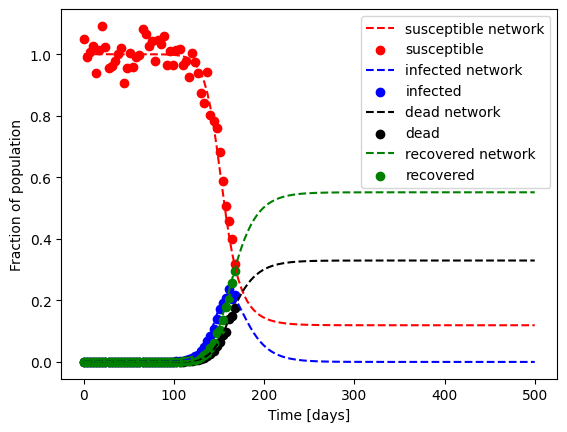

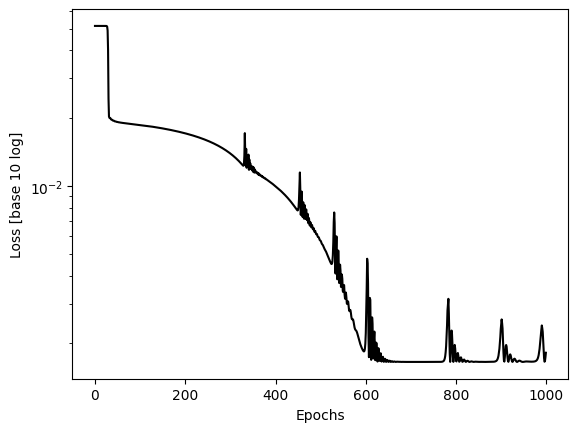

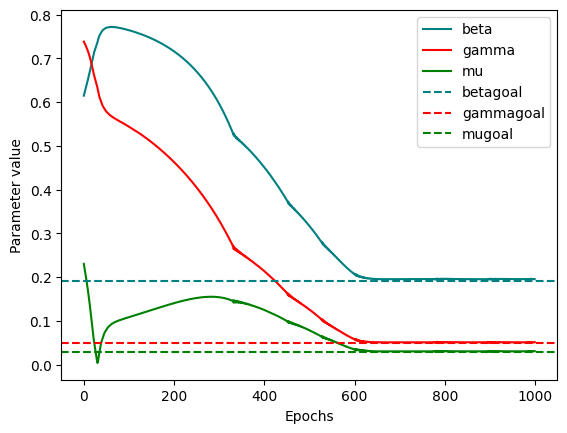

In [16]:
# constrained params
beta_con = np.tanh(betas)
gamma_con = np.tanh(gammas)
mu_con = np.tanh(mus)
beta_con = list(map(abs, beta_con))
gamma_con = list(map(abs, gamma_con))
mu_con = list(map(abs, mu_con))
print(beta_con[-1])
print(gamma_con[-1])
print(mu_con[-1])
ufull =  zeros([1,147,4])
#prediction results after training
yPred = model(ufull, initial_state) [0, :, :]
yPred = yPred.detach().numpy()

plt.plot(t, yPred[:,0], color = 'red', label = 'susceptible network', linestyle = 'dashed')
plt.scatter(ttrain, Strain, color = 'red', label = 'susceptible')
plt.plot(t, yPred[:,1], color = 'blue', label = 'infected network', linestyle = 'dashed')
plt.scatter(ttrain, Itrain, color = 'blue', label = 'infected')
plt.plot(t, yPred[:,3], color = 'black', label = 'dead network', linestyle = 'dashed')
plt.scatter(ttrain, Dtrain, color = 'black', label = 'dead')
plt.plot(t, yPred[:,2], color = 'green', label = 'recovered network', linestyle = 'dashed')
plt.scatter(ttrain, Rtrain, color = 'green', label = 'recovered')

#True values
plt.plot(t, Sc, color = 'red')
plt.plot(t, Ic, color = 'blue')
plt.plot(t, Dc, color = 'black')
plt.plot(t, Rc, color = 'green')

plt.legend()
#plt.title('Network recreation of training dataset')
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.show()

# Loss
plt.plot(losses,color = 'black')
plt.yscale("log")
#plt.title("Loss trend under Adam optimization")
plt.xlabel('Epochs')
plt.ylabel('Loss [base 10 log]')
plt.show()

# plot the learned SIRD parameters vs true SIRD parameters
plt.plot(beta_con[0:], color = 'teal', label ="beta")
plt.plot(gamma_con[0:], color = 'red', label="gamma")
plt.plot(mu_con[0:], color = 'green', label="mu")
plt.axhline(y = 0.191, color = 'teal', linestyle = 'dashed', label ="betagoal")
plt.axhline(y = 0.05, color = 'red', linestyle = 'dashed', label ="gammagoal")
plt.axhline(y = 0.0294, color = 'green', linestyle = 'dashed', label ="mugoal")
plt.legend()
#plt.title('Change in Parameter estimation')
plt.xlabel('Epochs')
plt.ylabel('Parameter value')
plt.show()